This notebook is to calculate the 6D peaks reconstruction object

In [1]:
#use this for interactive pop up images
#%matplotlib qt5

In [2]:
import hyperspy.api as hs
import pyxem as pxm
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt
import pandas as pd
import time
import gc
import os
from os.path import exists
from skimage.transform import resize

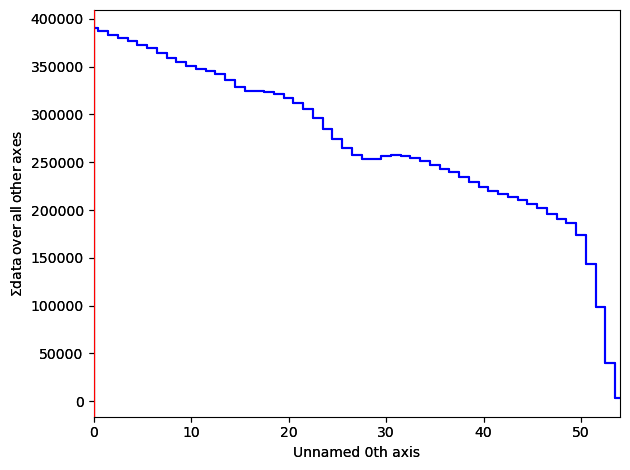

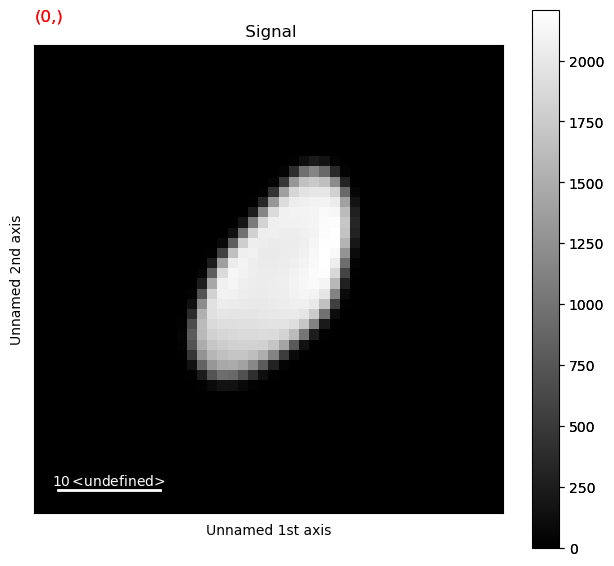

In [6]:
#load the reconstruction made with tomoviz

inpath = "D:/data/August2022/TiNi/tomo/"
rec = hs.load(inpath + "sirt10cut.tif")
rec.set_signal_type('electron_diffraction')

#resize the reconstruction to match the meanscale from Reconstruction.ipynb
meanscale = 0.7163452999020451
recb = resize(rec.data, ( np.round(meanscale*(rec.data.shape[0] / 4)), np.round(meanscale*(rec.data.shape[1] / 4)), np.round(meanscale*(rec.data.shape[2] / 4))), anti_aliasing=True)
recb = hs.signals.Signal2D(recb)
recb.set_signal_type('electron_diffraction')
#recb.plot(cmap='gray')
recbz, recby, recbx = recb.data.shape

del rec
gc.collect()
recb.plot(cmap='gray')

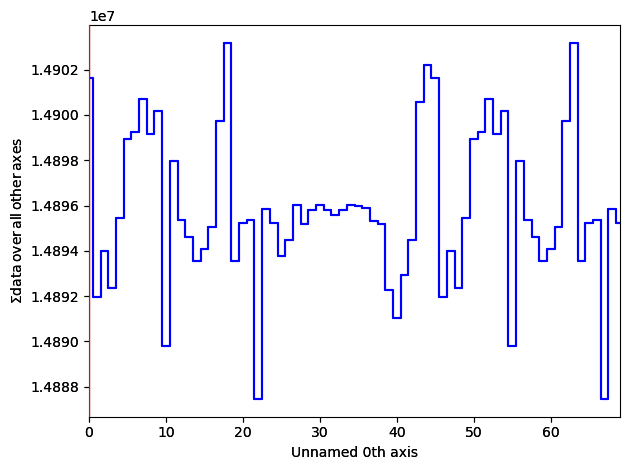

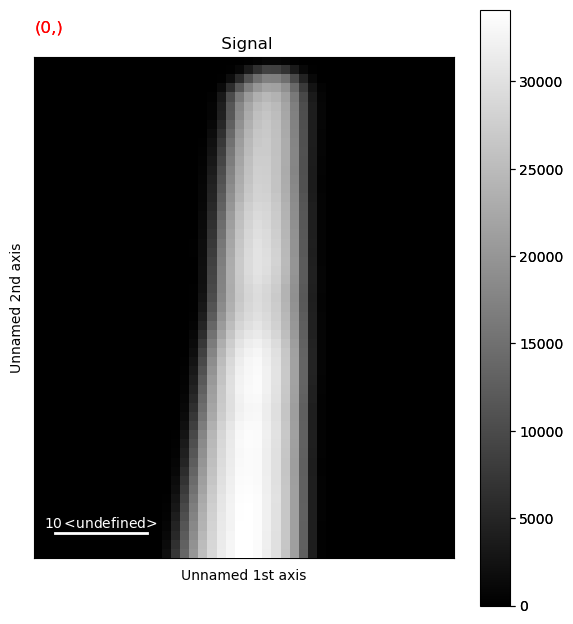

In [7]:
from skimage.transform import radon

# Get the reprojected tilt series from the reconstruction
# Change the tilt ranges here
Ntilts = 70
starttilt = -64
endtilt = 74
tiltstep = 2

proj= np.zeros((Ntilts,recb.data.shape[0], recb.data.shape[2]))

for ll in range(Ntilts):
    for l in range(recb.data.shape[0]):
        theta = np.linspace(starttilt + ll*tiltstep,1,1) 
        R=radon(recb.data[l,:,:],theta, circle=True)
        proj[ll,recb.data.shape[0]-l-1,:] = np.squeeze(R)

proj1 = hs.signals.Signal2D(proj)
proj1.set_signal_type('electron_diffraction')
proj1.plot(cmap='gray',norm='auto' )

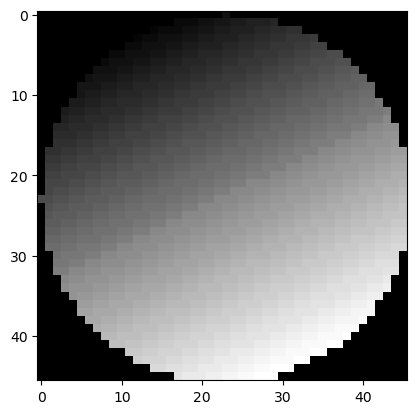

In [8]:
#get nearest neighbour radon image for the indexes
from skimage.transform import iradon

angles = np.linspace(starttilt,endtilt,Ntilts, endpoint=True, dtype=float)
dpsize = 256


y = recby
x = recbx
yy = np.linspace(1, y+1, y) # plus one to separate from 0 background
xx = np.linspace(0, 1, 1)
yv, xv = np.meshgrid(yy, xx)

theta=np.linspace(1,2,1)*(starttilt + 0*tiltstep)

Ra=iradon(yv.T,theta, output_size= y,  filter_name=None, interpolation = 'nearest', circle='True',preserve_range='True')#circle='True',
RaStack = np.zeros((Ntilts , Ra.shape[0], Ra.shape[1]))

for i in range(Ntilts):
    theta=np.linspace(1,2,1)*(starttilt + i*tiltstep)
    Ra=iradon(yv.T,theta, output_size= y,  filter_name=None, interpolation = 'nearest', circle='True',preserve_range='True')#circle='True',
    Ra = (Ra - Ra.min())
    Ra = Ra*( (y+1)/Ra.max())
    Ra = Ra.round()
    RaStack[i,:,:] = Ra
    
plt.imshow(RaStack[0,:,:],cmap='gray')

In [14]:
#Function to write peaks to 3d reconstruction list object

#path from TomoPeaks.ipynb
outpath2 = 'D:/data/August2022/TiNi/tomo/Tomo_23/post2/'


def write_peaks_to_voxels( plane, peaks_vol, RaStack, angles):

    print('plane',plane)

    test1 = 'peaks3d'
    path1 = outpath2 + 'peaks/'
    path = outpath2 + 'transforms/'

    with open(path1 + test1 + '.npy', 'rb') as f:
        v = np.load(f,allow_pickle=True)

    test = '4DSTEM_dp_tilt_noscale' 
    dp_tilt = hs.load(outpath2 + test + '.hdf5')
    
    Ra = RaStack[0,:,:]
    mask = np.zeros((RaStack.shape[1], RaStack.shape[2]),dtype=bool)
    mask[Ra>0] = True
    
    for tilt in range(RaStack.shape[0]): #RaStack.shape[0]

        test1 = 'transforms_' + str(tilt)
        Tx = sitk.ReadTransform(path + test1 + '.tfm')
        inv_Tx = Tx.GetInverse()
        
        dp_tilt0 = dp_tilt.data[tilt,:,:]
        Ra = RaStack[tilt,:,:]
        peakspertilt =  v[tilt,:,:]

        for i in range(peakspertilt.shape[1]- 1,-1,-1 ): # here we go through dp_tilt0 x axis [1] indexes, the y axis is the plane of the rec
            

            Ra1 = mask*Ra 

            Ra1[np.where(Ra==(i+1))] = -1 # +1 to match the +1 in the Ra definition
            Ra2 = np.abs(-1*np.where(Ra1>-1, 0, Ra1))
            rasum = Ra2.sum()
             
            for j in range(int(rasum)): #1,2 #rasum # here we put the dp tilt image into all of the em3d cubes with corresponding tilt angle
                                            # and with corresponding projection rays. one plane only
                ramax = Ra2.argmax()
                ramaxind = np.unravel_index(ramax, (Ra2.shape))        
        
                #transform points from dp_tilt0 back to original dp
                dp_tilt_point = (plane,i)
                dp_point = inv_Tx.TransformPoint(dp_tilt_point)
         
                trans_j = int(np.ceil(dp_point[0]))  #minus goes to the right
                trans_i = int(np.ceil(dp_point[1]))
                
            
                if trans_j <  peakspertilt.shape[0] and trans_j > 0: 
                    if trans_i <  peakspertilt.shape[1] and trans_i > 0:
                        if dp_tilt0[trans_j,trans_i] != 0: 
                            if recb.data[plane,ramaxind[0],ramaxind[1]] != 0: # skip the background  
                                
                                plist_old = peaks_vol[plane, ramaxind[0], ramaxind[1]] 

                                plist_new = peakspertilt[trans_j,trans_i]

                                for k in range(len(plist_new)):
                                    
                                    
                                    plist_new1 = []
                                    plist = []
                                    plist.append(tilt)
                                    plist.append(trans_j)
                                    plist.append(trans_i)
                                    plist.append(k)
                                    plist.extend(plist_new[k][0:4] )             # 3d position   
                                    #plist.append( np.linalg.norm(plist_new[k][0:3]) )# distance from (0,0,0)
                                    plist.append( plist_new[k][4])          #  intensity  

                                    plist_new1.append(plist)

                                   # if plist[4] > 0:

                                    if plist_old is None:

                                        plist_old = []
                                        plist_old.append(plist_new1)

                                    else:   

                                        if plist_new1[0][4:7] == [0.,0.,0.]:                                                                
                                                                                             # remove the (0,0,0) since it is already included
                                            plist_old[0][0][7] += plist_new1[0][7]

                                        else:
                                            plist_old.append(plist_new1)

                                    peaks_vol[plane, ramaxind[0], ramaxind[1]] = plist_old


                Ra2[ramaxind] = 0

        

    peakimg = np.zeros( (peaks_vol.shape[1],peaks_vol.shape[2]))
 
    #peakimg: how many peaks in a voxel
    for j in range(peaks_vol.shape[1]):
        for i in range(peaks_vol.shape[2]):
            plist_old = peaks_vol[plane,  j,i] 
            if plist_old is None:
                plist_old = []
                plist_old.extend([[(0,0,0,0,0,0,0,0)]])
                peaks_vol[plane, j,i] = plist_old 
            peakimg[j,i] = len( peaks_vol[plane, j,i])
 
    
    return peakimg

In [15]:
#Calculate all planes

angles = np.linspace(starttilt,endtilt,Ntilts, endpoint=True, dtype=float)

#the 3d peak list array
peaks_vol = np.empty((recbz, recby, recbx), dtype=object)
#number of peaks per voxel 3d image (for testing)
peakimg = np.zeros( (recbz, recby, recbx))

for plane in range(recbz): 
    peakimg[plane,:,:] = write_peaks_to_voxels(plane, peaks_vol, RaStack, angles)
    
test = '4DSTEM_peaks_vol'
np.save(outpath2 + test + '.npy', peaks_vol)

plane 0
plane 1
plane 2
plane 3
plane 4
plane 5
plane 6
plane 7
plane 8
plane 9
plane 10
plane 11
plane 12
plane 13
plane 14
plane 15
plane 16
plane 17
plane 18
plane 19
plane 20
plane 21
plane 22
plane 23
plane 24
plane 25
plane 26
plane 27
plane 28
plane 29
plane 30
plane 31
plane 32
plane 33
plane 34
plane 35
plane 36
plane 37
plane 38
plane 39
plane 40
plane 41
plane 42
plane 43
plane 44
plane 45
plane 46
plane 47
plane 48
plane 49
plane 50
plane 51
plane 52
plane 53
plane 54


In [17]:
#sum of peaks 3d

rec = np.zeros((recbz, recby, recbx)) 

for z in range(recbz):
 
    for j in range(recby):
        for i in range(recbx):
            #if peaks_vol[z,j,i] != None:
               # if len(peaks_vol[z,j,i]) > 1:
            kk = len(peaks_vol[z,j,i])
            
            for k in range(kk):
                p = peaks_vol[z,j,i][k][0][7]
                
                if p > 0: 

                    ii = peaks_vol[z,j,i][k][0][8]
                    rec[z,j,i] += ii


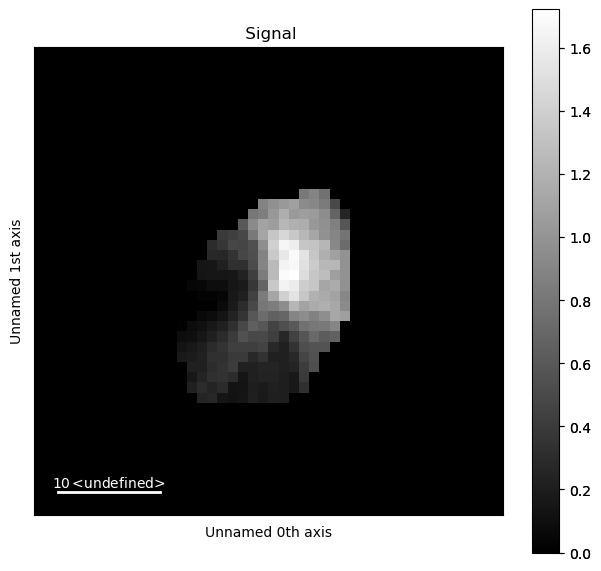

In [20]:
s = hs.signals.Signal2D(rec)
s.inav[28].plot(cmap='gray')

In [23]:
#save rec array
import mrcfile

name = 'peakrec2' + '.mrc'
with mrcfile.new(outpath2 + name,overwrite=True) as mrc:
    mrc.set_data(rec.astype('float32'))
    mrc.close()